In [9]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import colors as clr
import numpy as np
import sys
import re
import fileinput
from scipy.optimize import curve_fit
#import scipy as scp


# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data
bound_inds = []
oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    missed_line_inds = []
    temp_data = []
    temp_rad_zone_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        if match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
            #continue
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data

# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column',col_numb,'values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    # by
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        #print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs, col_vals

# To do for plots:
# X, Y axes labels
# 

# Function to plot multiple Teff or log(g) lines (for 1 filter output ONLY!)
# Input: dictionary of relevant arrays, pyplot axes name (text),fixed input variable values (list of strings)
def dict_2D_plot(input_dict,ax,col_x,col_y,var_names,col_map):
    label_int = 6
    if (col_x == 1):
        label_int = 1
    elif (col_x == 2):
        label_int = 0
        
    plt.gca().set_color_cycle([col_map(j) for j in np.linspace(1, 0, len(input_dict))])
    # grid_vals_dict gives the fixed value as the key for the array
    for i in reversed(sorted(input_dict.iterkeys())):
        ax.plot((input_dict[i])[:,(col_x-1)],(input_dict[i])[:,(col_y-1)],label=(var_names[label_int]+'='+i))
    ax.set_xlabel(var_names[(col_x-1)])
    ax.set_ylabel(var_names[(col_y-1)])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.1))
    #ax.set_title('Stuff',y=1.05)
    plt.show()
    
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    print len (combined_set)
    for key_val in combined_set:
        #print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict

# polynomial fit write-out function
def poly_fit_number_gen_write(f,xdata,ydata,poly_degs_arr,filter_str,logg_val):
    output_names = ['    Coefficients (in order of descending polynomial index):','    Sum of residuals:', '    Rank of coefficient matrix:', '    Singular values of coefficient matrix:', '    Cut-off ratio for small singular values of coefficient matrix:']
    print 'List of degrees for polynomial fitting for grid point: ',poly_degs_arr
    f.write('Fitting results for '+str(filter_str)+' filter, with log(g) = '+str(logg_val)+'\n')
    for i in poly_degs_arr:
        f.write('        Results for polynomial fit of degree ' + str(i) + ': \n')
        c = 0
        for j in np.polyfit(xdata,ydata,i,full=True):
            if (len(np.polyfit(xdata,ydata,i,full=True)) == len(output_names)):
                f.write(output_names[c])
                f.write('\n')
                f.write(str(j))
                f.write('\n')
                c += 1
            elif(len(np.polyfit(xdata,ydata,i,full=True)) > len(output_names)):
                print 'Error: Not enough headings for data'
            else:
                print 'Error: Not enough data fields for output'
        f.write('\n')
    f.write('\n')

# other fits write-out function

def general_fit_number_gen_write(f,func_coeffs,covar_matrix,filter_str,logg_val):
    output_names = ['    Fit coefficients (in order of functions'' arguments):','    Covariance matrix:']
    f.write('Fitting results for ' + str(filter_str) + ' filter, with log(g) = ' + str(logg_val) + '\n')
    f.write(output_names[0] + '\n')
    f.write(str(func_coeffs) + '\n')
    f.write(output_names[1] + '\n')
    f.write(str(covar_matrix) + '\n')
    f.write('\n')
    
    
# Modelling functions below!!!

# single power-law term
def single_poly(xdata,a,b,c):
    y = a*(xdata**b) + c
    return y

# exponential function
def exp_func(xdata,a,b,c):
    y = (a*(np.exp(b*xdata))) + c
    return y

# exponential function weighted by Teff^d
def single_poly_x_exp_func(xdata,a,b,c,d):
    y = (xdata**d)*(a*(np.exp(b*xdata))) + c
    return y

# exponential function added to Teff^d
def single_poly_plus_exp_func(xdata,a,b,c,d):
    y = (xdata**d) + (a*(np.exp(b*xdata))) + c
    return y

# logarithmic function
def log_func(xdata,a,b,c):
    y = (a*(np.log10(b*xdata))) + c
    return y

# logarithmic function weighted by Teff^d
def single_poly_x_log_func(xdata,a,b,c,d):
    y = (xdata**d) * (a*(np.log10(b*xdata))) + c
    return y

# logarithmic function added to Teff^d
def single_poly_plus_log_func(xdata,a,b,c,d):
    y = (xdata**d) + (a*(np.log10(b*xdata))) + c
    return y
    
print 'modules loaded & functions compiled'

modules loaded & functions compiled


In [3]:
# N.B.: usiing cgs unit
with open ("gaia_spectra/OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)

T_Av0zs = Av0zs_data[:,0]
log_g_Av0zs = Av0zs_data[:,1]
gaia_filter_G_Av0zs = Av0zs_data[:,2]
gaia_filter_G_bp_Av0zs = Av0zs_data[:,3]
gaia_filter_G_rp_Av0zs = Av0zs_data[:,4]

with open ("gaia_spectra/OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)
    
T_Av1zs = Av1zs_data[:,0]
log_g_Av1zs = Av1zs_data[:,1]
gaia_filter_G_Av1zs = Av1zs_data[:,2]
gaia_filter_G_bp_Av1zs = Av1zs_data[:,3]
gaia_filter_G_rp_Av1zs = Av1zs_data[:,4]

with open ("gaia_spectra/OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_data = data_read_gaia(Av0z2)
    
T_Av0z2 = Av0z2_data[:,0]
log_g_Av0z2 = Av0z2_data[:,1]
gaia_filter_G_Av0z2 = Av0z2_data[:,2]
gaia_filter_G_bp_Av0z2 = Av0z2_data[:,3]
gaia_filter_G_rp_Av0z2 = Av0z2_data[:,4]
    
with open ("gaia_spectra/OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av1z2_data = data_read_gaia(Av1z2)
    
T_Av1z2 = Av1z2_data[:,0]
log_g_Av1z2 = Av1z2_data[:,1]
gaia_filter_G_Av1z2 = Av1z2_data[:,2]
gaia_filter_G_bp_Av1z2 = Av1z2_data[:,3]
gaia_filter_G_rp_Av1z2 = Av1z2_data[:,4]

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
#print Av0z2_logg_fix['0.0']
print '****Separating data into arrays by Teff values****'
#Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_data,1)
#Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_data,1)
#Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_data,1)
#Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_data,1)
print '****Finished arrays****'
#print type(Av0zs_Teff_vals[0])
A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

#A_X_zs_Tfix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
#A_X_z2_Tfix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)


    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
****Separating data into arrays by Teff values****
****Finished arrays****
11
Raw A(X) dictionary complete
11
Raw A(X) dictionary complete


Teff^(a) * exponential fit coefficients: 
[  9.78603883e-01   1.45353411e-17  -1.00000000e+00   4.84618587e-01]
Covariance matrix: 
[[  2.24714938e+04   7.35607601e+02  -2.50009226e+04  -9.27361639e+03]
 [  7.35607601e+02   2.41078721e+01  -8.18352883e+02  -3.03674240e+02]
 [ -2.50009226e+04  -8.18352883e+02   2.78151832e+04   1.03172650e+04]
 [ -9.27361639e+03  -3.03674240e+02   1.03172650e+04   3.82743880e+03]]
Teff^(a) + exponential fit coefficients: 
[  1.71089510e-01   8.41196765e-10  -1.19895184e+00   4.79380402e-01]
Covariance matrix: 
[[  1.10148160e+11   1.36171238e+05  -1.10148176e+11  -2.91085868e+04]
 [  1.36171238e+05   7.24135475e+01  -1.36179168e+05  -1.54604031e+01]
 [ -1.10148176e+11  -1.36179168e+05   1.10148192e+11   2.91102793e+04]
 [ -2.91085868e+04  -1.54604031e+01   2.91102793e+04   3.30105372e+00]]


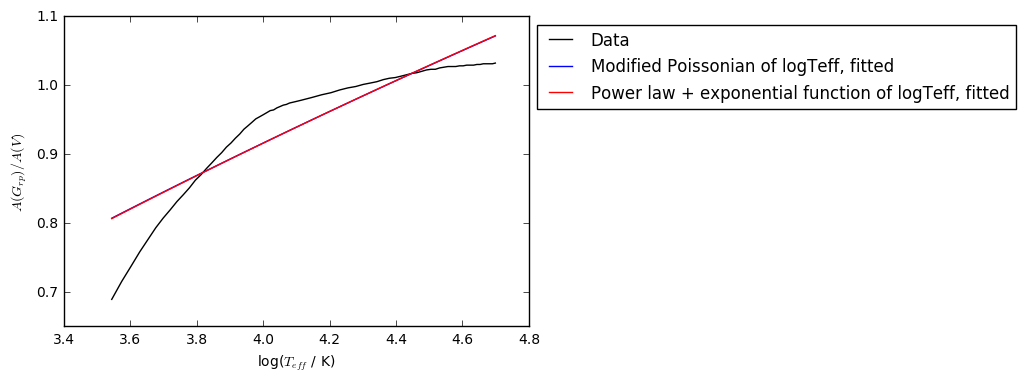

Exponential fit coefficients: 
[ -7.26543212e-01  -2.39459351e-04   1.02037796e+00]
Covariance matrix: 
[[  3.71617665e-04   9.41823367e-08   8.32496986e-06]
 [  9.41823367e-08   2.84919372e-11   4.17126017e-09]
 [  8.32496986e-06   4.17126017e-09   1.91613048e-06]]
Teff^(n) * exponential fit coefficients: 
[ -8.87477859e-01  -2.91932421e-04   1.00000000e+00  -5.47949945e-03]
Covariance matrix: 
[[  7.17394503e+00  -1.85514487e-04  -2.60383560e-03   1.06121477e+00]
 [ -1.85514487e-04   5.03629245e-09   8.94762077e-08  -2.75701351e-05]
 [ -2.60383560e-03   8.94762077e-08   7.99732520e-06  -3.93360754e-04]
 [  1.06121477e+00  -2.75701351e-05  -3.93360754e-04   1.57057445e-01]]
Teff^(n) + exponential fit coefficients: 
[ -8.26149380e-01  -3.33296162e-04  -2.79215145e-01   2.52357415e-02]
Covariance matrix: 
[[  2.03360418e-04   6.98256609e-08   6.77004735e-05  -4.91938057e-06]
 [  6.98256609e-08   3.09263414e-11   4.35113148e-08  -3.19876764e-09]
 [  6.77004735e-05   4.35113148e-08   9.10

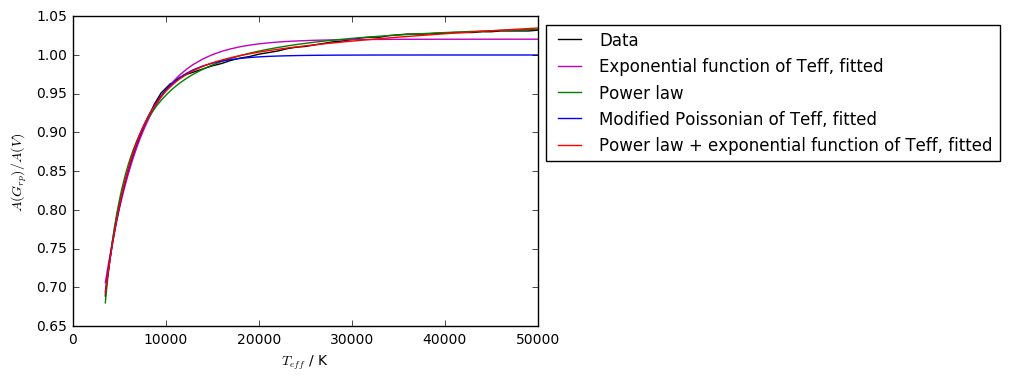

Predicted values:  0.70612792982 0.761233581786 0.723305639441
Actual data value =  0.689
Log fit coefficients: 
[ 0.22744533  0.0346625   0.33699496]
Covariance matrix: 
[[  1.60229063e-04  -3.76253037e+01   1.07220950e+02]
 [ -3.76253037e+01   4.85657686e+11  -1.38398590e+12]
 [  1.07220950e+02  -1.38398590e+12   3.94396512e+12]]
Teff^(a) * log fit coefficients: 
[  2.27445333e-01   3.30596933e+00  -1.13219199e-01   2.67285448e-25]
Covariance matrix: 
[[  1.47395430e-01   5.98140428e+04  -1.78753356e+03  -3.17313677e-02]
 [  5.98140428e+04   4.83915373e+12  -1.44588043e+11  -1.28292366e+04]
 [ -1.78753356e+03  -1.44588043e+11   4.32011533e+09   3.83399992e+02]
 [ -3.17313677e-02  -1.28292366e+04   3.83399992e+02   6.83868399e-03]]
Teff^(a) + log fit coefficients: 
[  2.27447090e-01   3.34288770e-02  -6.59431208e-01   9.52250126e-08]
Covariance matrix: 
[[  3.13766541e+10  -2.58112804e+09   5.39349684e+10  -1.36266809e+10]
 [ -2.58112804e+09   1.24066982e+11  -3.70414964e+11   1.12096

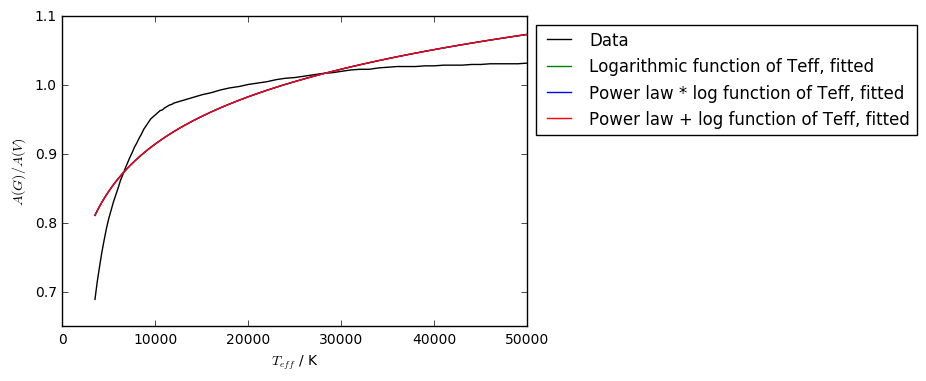


    Writing log(g)=5.0, Z = Zsolar model
writing complete


In [ ]:
# log(Teff) array fitting

# exponential function of log(Teff) not included, as this is just a power law in T
var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$','log($T_{eff}$ / K)']
#'$T_{eff}$ / K'
Teff_5_zs = (A_X_zs_gfix['5.0'])[:,0]
# convert Teff to logs
log_Teff_5_zs = np.log10(Teff_5_zs)
A_G_5_zs = (A_X_zs_gfix['5.0'])[:,2]
A_Gbp_5_zs = (A_X_zs_gfix['5.0'])[:,3]
A_Grp_5_zs = (A_X_zs_gfix['5.0'])[:,4]

Teff_5_z2 = (A_X_z2_gfix['5.0'])[:,0]
# convert Teff to logs
log_Teff_5_z2 = np.log10(Teff_5_z2)
A_G_5_z2 = (A_X_z2_gfix['5.0'])[:,2]
A_Gbp_5_z2 = (A_X_z2_gfix['5.0'])[:,3]
A_Grp_5_z2 = (A_X_z2_gfix['5.0'])[:,4]

#,method='lm'
#try:
#except RuntimeError:
#    print "Error - curve_fit exponential failed"
#log_fit_A_G5zs_logT, covarr_A_G5zs_lf_logT = curve_fit(log_func,log_Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([1.0e-02,1.0e-02,1.0e-02], [1., 2., 10.]))
spx_exp_fit_A_G5zs_logT, covarr_A_G5zs_spx_logT = curve_fit(single_poly_x_exp_func,log_Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([0.,0.,-1.,-10.], [10., 10., 10., 10.]))
spp_exp_fit_A_G5zs_logT, covarr_A_G5zs_spp_logT = curve_fit(single_poly_plus_exp_func,log_Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([0.,0.,-10.,-10.], [10., 10., 100., 100.]))

#print 'Log fit coefficients: '
#print log_fit_A_G5zs_logT
#print 'Covariance matrix: '
#print covarr_A_G5zs_lf_logT

print 'Teff^(a) * exponential fit coefficients: '
print spx_exp_fit_A_G5zs_logT
print 'Covariance matrix: '
print covarr_A_G5zs_spx_logT

print 'Teff^(a) + exponential fit coefficients: '
print spp_exp_fit_A_G5zs_logT
print 'Covariance matrix: '
print covarr_A_G5zs_spp_logT

fig, ax = plt.subplots()
ax.set_xlabel(var_names[5])
ax.set_ylabel(var_names[4])

ax.plot(log_Teff_5_zs,A_G_5_zs,'k',label='Data')
#ax.plot(log_Teff_5_zs,log_func(log_Teff_5_zs,*log_fit_A_G5zs_logT),'g',label='Logarithmic function of logTeff, fitted')
ax.plot(log_Teff_5_zs,single_poly_x_exp_func(log_Teff_5_zs,*spx_exp_fit_A_G5zs_logT),'b',label='Modified Poissonian of logTeff, fitted')
ax.plot(log_Teff_5_zs,single_poly_plus_exp_func(log_Teff_5_zs,*spp_exp_fit_A_G5zs_logT),'r',label='Power law + exponential function of logTeff, fitted')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AG_logTeff_exp_plot_test.pdf', bbox_inches='tight')


"""
#ax.plot(Teff_5_zs,A_Gbp_5_zs,'r',label='Z = Z$_{\odot}$')
#ax.plot(Teff_5_z2,A_Gbp_5_z2,'g',label='Z = 10$^{-2}$ Z$_{\odot}$')

print len(A_X_zs_Tfix)

fig,ax = plt.subplots()
col_map = plt.cm.gnuplot
dict_2D_plot(A_X_zs_Tfix,ax,2,3,var_names,col_map)
plt.show()
"""

#,method='lm'
#try:
exp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([-10.,-1.0e-01,-5.], [0., 1.0e-01, 5.]))
spx_exp_fit_A_G5zs, covarr_A_G5zs_spx = curve_fit(single_poly_x_exp_func,Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([-10.,-1.0e-03,-1.,-1.], [0., 1.0e-03, 1., 1.]))
spp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([-1.,-1.0e-02,-1.,0.], [0., 0., 0., 1.0e-01]))
pow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([-1.0e+04,-5.0,-5.], [0., 1.0, 5.]))
print 'Exponential fit coefficients: '
print exp_fit_A_G5zs
print 'Covariance matrix: '
print covarr_A_G5zs_ef

print 'Teff^(n) * exponential fit coefficients: '
print spx_exp_fit_A_G5zs
print 'Covariance matrix: '
print covarr_A_G5zs_spx

print 'Teff^(n) + exponential fit coefficients: '
print spp_exp_fit_A_G5zs
print 'Covariance matrix: '
print covarr_A_G5zs_spp

print 'Teff^(n) fit coefficients: '
print pow_fit_A_G5zs
print 'Covariance matrix: '
print covarr_A_G5zs_pow



#except RuntimeError:
#    print("Error - curve_fit exponential failed")


fig, ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[4])

ax.plot(Teff_5_zs,A_G_5_zs,'k',label='Data')
ax.plot(Teff_5_zs,exp_func(Teff_5_zs,*exp_fit_A_G5zs),'m',label='Exponential function of Teff, fitted')
ax.plot(Teff_5_zs,single_poly(Teff_5_zs,*pow_fit_A_G5zs),'g',label='Power law')
ax.plot(Teff_5_zs,single_poly_x_exp_func(Teff_5_zs,*spx_exp_fit_A_G5zs),'b',label='Modified Poissonian of Teff, fitted')
ax.plot(Teff_5_zs,single_poly_plus_exp_func(Teff_5_zs,*spp_exp_fit_A_G5zs),'r',label='Power law + exponential function of Teff, fitted')
#ax.plot(Teff_5_zs,single_poly_x_exp_func(Teff_5_zs,-9.26543212e-01,-2.39459351e-04 ,1.02037796e+00,1.4e-03),'g',label='dfgiugdfgdr')

#print 'Testing log curve'
#print Teff_5_zs
#print log_func(Teff_5_zs,0.22744533,0.17575513,0.17663504)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AG_Teff_exp_plot_test.pdf', bbox_inches='tight')

#ax.plot(Teff_5_zs,A_Gbp_5_zs,'r',label='Z = Z$_{\odot}$')
#ax.plot(Teff_5_z2,A_Gbp_5_z2,'g',label='Z = 10$^{-2}$ Z$_{\odot}$')
exp_test_begin =  exp_func(Teff_5_zs[0],-7.26540361e-01,-2.39458489e-04,1.02037808e+00)
#log_test_begin =  log_func(Teff_5_zs[0],-7.26540361e-01,-2.39458489e-04,1.02037808e+00)
spx_test_begin = single_poly_x_exp_func(Teff_5_zs[0],9.05023884e+00,-2.01320841e-07,-1.00000000e+01,2.13054689e-02)
spp_test_begin = single_poly_plus_exp_func(Teff_5_zs[0],-7.26149370e-01,-3.33296157e-04,-2.79215137e-01,2.52357409e-02)
print 'Predicted values: ',exp_test_begin,spx_test_begin,spp_test_begin
print 'Actual data value = ',A_G_5_zs[0]

# log function fits & plots
log_fit_A_G5zs, covarr_A_G5zs_lf = curve_fit(log_func,Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([0.1,1.0e-03,0.], [10., 1., 10.]))
spx_log_fit_A_G5zs, covarr_A_G5zs_spxl = curve_fit(single_poly_x_log_func,Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([0.,1.0e-03,-3.,0.], [10., 10., 3., 1.]))
spp_log_fit_A_G5zs, covarr_A_G5zs_sppl = curve_fit(single_poly_plus_log_func,Teff_5_zs,A_G_5_zs, p0=None, sigma=None,bounds=([0.,1.0e-05,-1.,0.], [10., 1., 10., 1.]))

print 'Log fit coefficients: '
print log_fit_A_G5zs
print 'Covariance matrix: '
print covarr_A_G5zs_lf

print 'Teff^(a) * log fit coefficients: '
print spx_log_fit_A_G5zs
print 'Covariance matrix: '
print covarr_A_G5zs_spxl

print 'Teff^(a) + log fit coefficients: '
print spp_log_fit_A_G5zs
print 'Covariance matrix: '
print covarr_A_G5zs_sppl

fig, ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[2])

ax.plot(Teff_5_zs,A_G_5_zs,'k',label='Data')
ax.plot(Teff_5_zs,log_func(Teff_5_zs,*log_fit_A_G5zs),'g',label='Logarithmic function of Teff, fitted')
ax.plot(Teff_5_zs,single_poly_x_log_func(Teff_5_zs,*spx_log_fit_A_G5zs),'b',label='Power law * log function of Teff, fitted')
ax.plot(Teff_5_zs,single_poly_plus_log_func(Teff_5_zs,*spp_log_fit_A_G5zs),'r',label='Power law + log function of Teff, fitted')
#ax.plot(Teff_5_zs,single_poly_x_exp_func(Teff_5_zs,-9.26543212e-01,-2.39459351e-04 ,1.02037796e+00,1.4e-03),'g',label='dfgiugdfgdr')

#print 'Testing log curve'
#print Teff_5_zs
#print log_func(Teff_5_zs,0.22744533,0.17575513,0.17663504)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AG_Teff_log_plot_test.pdf', bbox_inches='tight')

with open ("gaia_spectra/Teff_AG_gen_fit_logg=5_zs_numbers",'w') as f:
    print '\n    Writing log(g)=5.0, Z = Zsolar model'
    general_fit_number_gen_write(f,spx_exp_fit_A_G5zs_logT, covarr_A_G5zs_spx_logT,'G',5.0)
    general_fit_number_gen_write(f,spp_exp_fit_A_G5zs_logT, covarr_A_G5zs_spp_logT,'G',5.0)
    
    general_fit_number_gen_write(f,pow_fit_A_G5zs, covarr_A_G5zs_ef,'G',5.0)
    general_fit_number_gen_write(f,exp_fit_A_G5zs, covarr_A_G5zs_ef,'G',5.0)
    general_fit_number_gen_write(f,spx_exp_fit_A_G5zs, covarr_A_G5zs_spx,'G',5.0)
    general_fit_number_gen_write(f,spp_exp_fit_A_G5zs, covarr_A_G5zs_spx,'G',5.0)
    
    general_fit_number_gen_write(f,log_fit_A_G5zs, covarr_A_G5zs_lf,'G',5.0)
    general_fit_number_gen_write(f,spx_log_fit_A_G5zs, covarr_A_G5zs_spxl,'G',5.0)
    general_fit_number_gen_write(f,spp_log_fit_A_G5zs, covarr_A_G5zs_sppl,'G',5.0)
    
    f.close()
    print 'writing complete'

In [37]:
"""fig, gfix = plt.subplots()
# colormap stuff
nipy_spectral
plt.gca().set_color_cycle([col_map(i) for i in np.linspace(0, 0.90, len(Av0z2_logg_fix))])



fig, ax = plt.subplots()
col_map = plt.cm.gnuplot
#gnuplot gist_ncar
#ax.set_xlim(0,15000)
#ax.set_ylim(-2,0)
dict_2D_plot(A_X_zs_gfix,ax,1,3,var_names,col_map)
fig.savefig('gaia_spectra/gaia_graphs/AG_vs_Teff_at_diff_logg.pdf', bbox_inches='tight')
"""
Teff_5_zs = (A_X_zs_gfix['5.0'])[:,0]
A_G_5_zs = (A_X_zs_gfix['5.0'])[:,2]
A_Gbp_5_zs = (A_X_zs_gfix['5.0'])[:,3]
A_Grp_5_zs = (A_X_zs_gfix['5.0'])[:,4]
"""
# plot all 3 filters against Teff together
fig,ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel('A(filter)')
ax.plot(Teff_5_zs,A_G_5_zs,'r', label = 'log(g) = 5, $A(G)$ curve')
ax.plot(Teff_5_zs,A_Gbp_5_zs,'g', label = 'log(g) = 5, $A(G_{bp})$ curve')
ax.plot(Teff_5_zs,A_Grp_5_zs,'b', label = 'log(g) = 5, $A(G_{rp})$ curve')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')
"""
#fit0_p3 = np.polyfit(Teff_5,A_G_5,3)
#print fit0_p3

#fit_G5zs_p3 = np.polyfit(Teff_5_zs,A_G_5_zs,3)
#print fit_G5zs_p3
#fit_G5zs_p2,covout_G_zs = np.polyfit(Teff_5_zs,A_G_5_zs,2,cov=True)
#print fit_G5zs_p2
#print covout_G_zs
fit_G5zs_p4, cov_G5zs_p4 = np.polyfit(Teff_5_zs,A_G_5_zs,4,cov=True)
fit_G5zs_p5, cov_G5zs_p5 = np.polyfit(Teff_5_zs,A_G_5_zs,5,cov=True)
fit_G5zs_p6, cov_G5zs_p6 = np.polyfit(Teff_5_zs,A_G_5_zs,6,cov=True)
fit_G5zs_p7, cov_G5zs_p7 = np.polyfit(Teff_5_zs,A_G_5_zs,7,cov=True)
#print fit_G5zs_p4

#fit_Gbp5zs_p3 = np.polyfit(Teff_5_zs,A_Gbp_5_zs,3)
#print fit_G5zs_p3
#fit_Gbp5zs_p2,covout_Gbp_zs = np.polyfit(Teff_5_zs,A_Gbp_5_zs,2,cov=True)
#print fit_Gbp5zs_p2
#print covout_Gbp_zs
fit_Gbp5zs_p4, cov_Gbp5zs_p4 = np.polyfit(Teff_5_zs,A_Gbp_5_zs,4,cov=True)
fit_Gbp5zs_p5, cov_Gbp5zs_p5 = np.polyfit(Teff_5_zs,A_Gbp_5_zs,5,cov=True)
fit_Gbp5zs_p6, cov_Gbp5zs_p6 = np.polyfit(Teff_5_zs,A_Gbp_5_zs,6,cov=True)
fit_Gbp5zs_p7, cov_Gbp5zs_p7 = np.polyfit(Teff_5_zs,A_Gbp_5_zs,7,cov=True)
#print fit_Gbp5zs_p4

#fit_Grp5zs_p3 = np.polyfit(Teff_5_zs,A_Grp_5_zs,3)
#print fit_G5zs_p3
#fit_Grp5zs_p2,covout_Grp = np.polyfit(Teff_5_zs,A_Grp_5_zs,2,cov=True)
#print fit_Grp5zs_p2
#print covout_Grp
fit_Grp5zs_p4, cov_Grp5zs_p4 = np.polyfit(Teff_5_zs,A_Grp_5_zs,4,cov=True)
fit_Grp5zs_p5, cov_Grp5zs_p5 = np.polyfit(Teff_5_zs,A_Grp_5_zs,5,cov=True)
fit_Grp5zs_p6, cov_Grp5zs_p6 = np.polyfit(Teff_5_zs,A_Grp_5_zs,6,cov=True)
fit_Grp5zs_p7, cov_Grp5zs_p7 = np.polyfit(Teff_5_zs,A_Grp_5_zs,7,cov=True)
#print fit_G5zs_p4

test_list = [1,2,3,4]
print type(test_list)
if (type(test_list) == list):
    print 'Okily-dokily'
else:
    print 'Diddly-ding-dong-CRAP!'
    
#print type(type(test_list))
for i in np.polyfit(Teff_5_zs,A_Grp_5_zs,7,full=True):
#print type(np.polyfit(Teff_5_zs,A_Grp_5_zs,7,full=True))
    print type(i)
    print i

# write out
with open ("gaia_spectra/Teff_poly_fit_logg=5_zs_numbers",'w') as f:
    print '\n    Writing log(g)=5.0, Z = Zsolar model'
    # polynomial Teff fits
    poly_degs_arr = [4,5,6,7]
    poly_fit_number_gen_write(f,Teff_5_zs,A_G_5_zs,poly_degs_arr,'G',5.0)
    poly_fit_number_gen_write(f,Teff_5_zs,A_Gbp_5_zs,poly_degs_arr,'G_bp',5.0)
    poly_fit_number_gen_write(f,Teff_5_zs,A_Grp_5_zs,poly_degs_arr,'G_rp',5.0)
    f.close()
    print 'writing complete'

<type 'list'>
Okily-dokily
<type 'numpy.ndarray'>
[  4.07777407e-32  -8.21546506e-27   6.78156126e-22  -2.95471777e-17
   7.29291457e-13  -1.01589007e-08   7.45949055e-05   4.38680114e-01]
<type 'numpy.ndarray'>
[ 0.00032826]
<type 'int'>
8
<type 'numpy.ndarray'>
[  2.62483735e+00   9.72569710e-01   3.93756027e-01   9.43854665e-02
   1.93951505e-02   2.89167953e-03   3.07685384e-04   2.25660885e-05]
<type 'numpy.float64'>
1.68753899743e-14

    Writing log(g)=5.0, Z = Zsolar model
List of degrees for polynomial fitting for grid point:  [4, 5, 6, 7]
List of degrees for polynomial fitting for grid point:  [4, 5, 6, 7]
List of degrees for polynomial fitting for grid point:  [4, 5, 6, 7]
writing complete


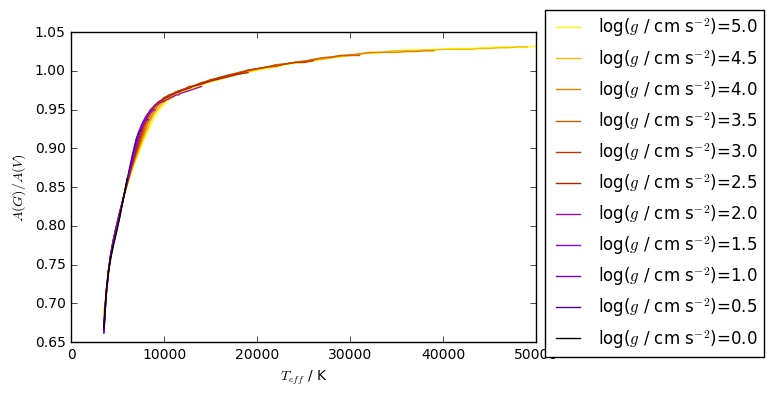

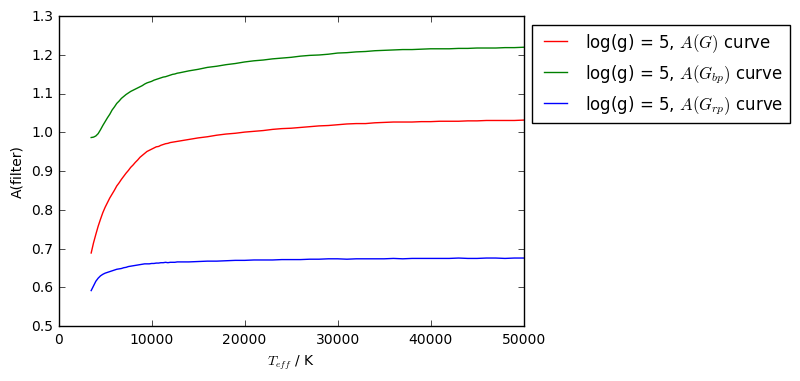

[ -2.61408749e-10   1.74301123e-05   7.64224846e-01]
[[  8.29674499e-22  -4.10549407e-17   3.21391071e-13]
 [ -4.10549407e-17   2.13247941e-12  -1.79035269e-08]
 [  3.21391071e-13  -1.79035269e-08   1.84362201e-04]]
[ -1.83153466e-10   1.30026242e-05   9.97603639e-01]
[[  2.66213664e-22  -1.31731013e-17   1.03123206e-13]
 [ -1.31731013e-17   6.84238405e-13  -5.74461853e-09]
 [  1.03123206e-13  -5.74461853e-09   5.91554121e-05]]
[ -5.06695103e-11   3.34703561e-06   6.25142563e-01]
[[  4.67253021e-23  -2.31211699e-18   1.80999837e-14]
 [ -2.31211699e-18   1.20096188e-13  -1.00828422e-09]
 [  1.80999837e-14  -1.00828422e-09   1.03828424e-05]]
<type 'numpy.ndarray'> (76L,)
<type 'numpy.ndarray'> (76L,)
[  4.11715153e-23  -6.19469832e-18   3.53893864e-13  -9.55717776e-09
   1.23362809e-04   3.81661212e-01]
[ -1.59109696e-27   2.91947389e-22  -2.14240691e-17   8.01095971e-13
  -1.60794104e-08   1.66708333e-04   2.82091162e-01]


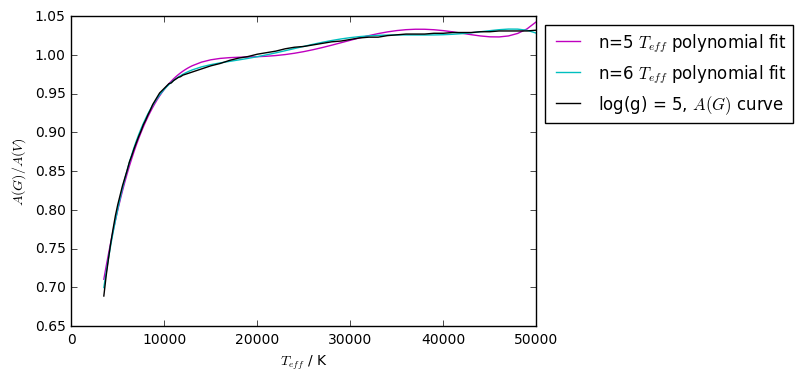

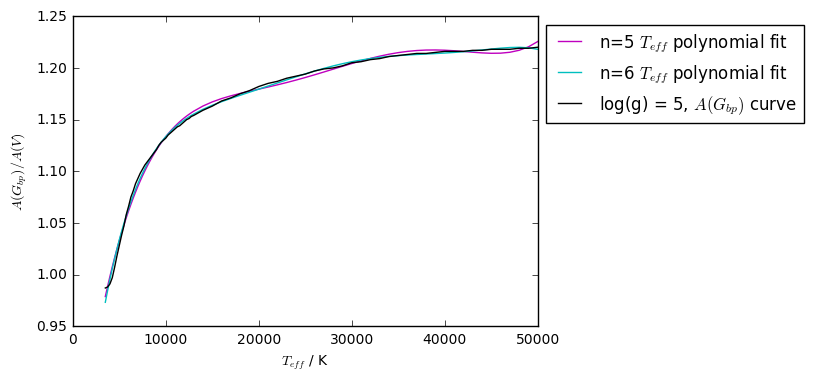

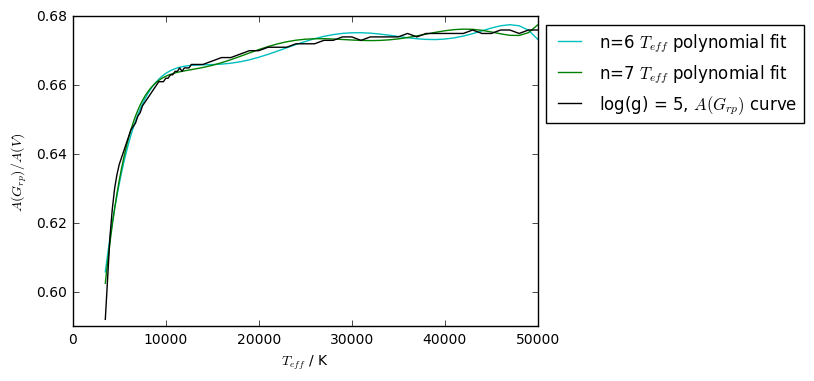

''

In [49]:
# G filter predictive curves
#predict_G5zs_2 = (fit_G5zs_p2[0])*Teff_5_zs**2 + (fit_G5zs_p2[1])*Teff_5_zs +(fit_G5zs_p2[2])
#predict_G5zs_3 = (fit_G5zs_p3[0])*Teff_5_zs**3 + (fit_G5zs_p3[1])*Teff_5_zs**2 + (fit_G5zs_p3[2])*Teff_5_zs +(fit_G5zs_p3[3])
#predict_G5zs_4 = (fit_G5zs_p4[0])*Teff_5_zs**4 + (fit_G5zs_p4[1])*Teff_5_zs**3 + (fit_G5zs_p4[2])*Teff_5_zs**2 + (fit_G5zs_p4[3])*Teff_5_zs + (fit_G5zs_p4[4])
predict_G5zs_5 = (fit_G5zs_p5[0])*Teff_5_zs**5 + (fit_G5zs_p5[1])*Teff_5_zs**4 + (fit_G5zs_p5[2])*Teff_5_zs**3 + (fit_G5zs_p5[3])*Teff_5_zs**2 + (fit_G5zs_p5[4])*Teff_5_zs +(fit_G5zs_p5[5])
predict_G5zs_6 = (fit_G5zs_p6[0])*Teff_5_zs**6 + (fit_G5zs_p6[1])*Teff_5_zs**5 + (fit_G5zs_p6[2])*Teff_5_zs**4 + (fit_G5zs_p6[3])*Teff_5_zs**3 + (fit_G5zs_p6[4])*Teff_5_zs**2 + (fit_G5zs_p6[5])*Teff_5_zs +(fit_G5zs_p6[6])
print type(predict_G5zs_2), predict_G5zs_2.shape
print type(predict_G5zs_3), predict_G5zs_3.shape
print fit_G5zs_p5
print fit_G5zs_p6

# G filter plot
fig,ax = plt.subplots()
#ax.set_title
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[2])

#ax.plot(Teff_5_zs,predict_G5zs_2,'r', label = 'n=2 $T_{eff}$ polynomial fit')
#ax.plot(Teff_5_zs,predict_G5zs_3,'g', label = 'n=3 $T_{eff}$ polynomial fit')
#ax.plot(Teff_5_zs,predict_G5zs_4,'b', label = 'n=4 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,predict_G5zs_5,'m', label = 'n=5 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,predict_G5zs_6,'c', label = 'n=6 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,A_G_5_zs,'k', label = 'log(g) = 5, $A(G)$ curve')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AG_vs_Teff_with_n=5_6_polyfit.pdf', bbox_inches='tight')

# G_bp filter calcs and plot

predict_Gbp5zs_5 = (fit_Gbp5zs_p5[0])*Teff_5_zs**5 + (fit_Gbp5zs_p5[1])*Teff_5_zs**4 + (fit_Gbp5zs_p5[2])*Teff_5_zs**3 + (fit_Gbp5zs_p5[3])*Teff_5_zs**2 + (fit_Gbp5zs_p5[4])*Teff_5_zs +(fit_Gbp5zs_p5[5])
predict_Gbp5zs_6 = (fit_Gbp5zs_p6[0])*Teff_5_zs**6 + (fit_Gbp5zs_p6[1])*Teff_5_zs**5 + (fit_Gbp5zs_p6[2])*Teff_5_zs**4 + (fit_Gbp5zs_p6[3])*Teff_5_zs**3 + (fit_Gbp5zs_p6[4])*Teff_5_zs**2 + (fit_Gbp5zs_p6[5])*Teff_5_zs +(fit_Gbp5zs_p6[6])

fig,ax = plt.subplots()
#ax.set_title
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[3])

#ax.plot(Teff_5_zs,predict_Gbp5zs_2,'r', label = 'n=2 $T_{eff}$ polynomial fit')
#ax.plot(Teff_5_zs,predict_Gbp5zs_3,'g', label = 'n=3 $T_{eff}$ polynomial fit')
#ax.plot(Teff_5_zs,predict_Gbp5zs_4,'b', label = 'n=4 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,predict_Gbp5zs_5,'m', label = 'n=5 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,predict_Gbp5zs_6,'c', label = 'n=6 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,A_Gbp_5_zs,'k', label = 'log(g) = 5, $A(G_{bp})$ curve')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AGbp_vs_Teff_with_n=5_6_polyfit.pdf', bbox_inches='tight')

# G_rp filter calcs and plot

predict_Grp5zs_5 = (fit_Grp5zs_p5[0])*Teff_5_zs**5 + (fit_Grp5zs_p5[1])*Teff_5_zs**4 + (fit_Grp5zs_p5[2])*Teff_5_zs**3 + (fit_Grp5zs_p5[3])*Teff_5_zs**2 + (fit_Grp5zs_p5[4])*Teff_5_zs +(fit_Grp5zs_p5[5])
predict_Grp5zs_6 = (fit_Grp5zs_p6[0])*Teff_5_zs**6 + (fit_Grp5zs_p6[1])*Teff_5_zs**5 + (fit_Grp5zs_p6[2])*Teff_5_zs**4 + (fit_Grp5zs_p6[3])*Teff_5_zs**3 + (fit_Grp5zs_p6[4])*Teff_5_zs**2 + (fit_Grp5zs_p6[5])*Teff_5_zs +(fit_Grp5zs_p6[6])
predict_Grp5zs_7 = (fit_Grp5zs_p7[0])*Teff_5_zs**7 + (fit_Grp5zs_p7[1])*Teff_5_zs**6 + (fit_Grp5zs_p7[2])*Teff_5_zs**5 + (fit_Grp5zs_p7[3])*Teff_5_zs**4 + (fit_Grp5zs_p7[4])*Teff_5_zs**3 + (fit_Grp5zs_p7[5])*Teff_5_zs**2 + (fit_Grp5zs_p7[6])*Teff_5_zs +(fit_Grp5zs_p7[7])

fig,ax = plt.subplots()
#ax.set_title
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[4])

#ax.plot(Teff_5_zs,predict_Gbp5zs_2,'r', label = 'n=2 $T_{eff}$ polynomial fit')
#ax.plot(Teff_5_zs,predict_Gbp5zs_3,'g', label = 'n=3 $T_{eff}$ polynomial fit')
#ax.plot(Teff_5_zs,predict_Gbp5zs_4,'b', label = 'n=4 $T_{eff}$ polynomial fit')
#ax.plot(Teff_5_zs,predict_Grp5zs_5,'m', label = 'n=5 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,predict_Grp5zs_6,'c', label = 'n=6 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,predict_Grp5zs_7,'g', label = 'n=7 $T_{eff}$ polynomial fit')
ax.plot(Teff_5_zs,A_Grp_5_zs,'k', label = 'log(g) = 5, $A(G_{rp})$ curve')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AGrp_vs_Teff_with_n=6_7_polyfit.pdf', bbox_inches='tight')

#scp.interpolate.griddata(,,,cubic)
""""""

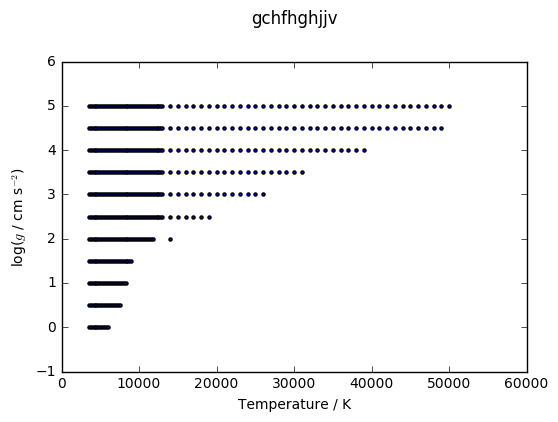

In [44]:
fig, ax = plt.subplots()
#ax.axhline(y=0.0, color='m', linestyle='--')
# Create a continuous norm to map from data points to colors | np.log10((Dthm+1).min()),np.log10((Dthm+1).max())
ax.scatter(T_Av0zs,log_g_Av0zs,marker='.')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('log($g$ / cm s$^{-2}$)')
#ax.set_xlim([0.02, 0.1])
#ax.set_ylim([0, 0.1])
#plt.show()
#ax.set_title('gchfhghjjv', y=1.1)
fig.savefig('gaia_spectra/gaia_graphs/hgchgftf.pdf', bbox_inches='tight')

[ -2.61408749e-10   1.74301123e-05   7.64224846e-01]
[[  8.79079860e-20  -1.41784710e-15   5.09834192e-12]
 [ -1.41784710e-15   2.35734990e-11  -8.77369414e-08]
 [  5.09834192e-12  -8.77369414e-08   3.43596776e-04]]
<type 'numpy.ndarray'> (35L,)
<type 'numpy.ndarray'> (35L,)
[  1.97054979e-20  -8.40419837e-16   1.41415776e-11  -1.22153064e-07
   5.83055496e-04  -3.56718470e-01]
[ -1.75294599e-23   9.04995000e-19  -1.88096742e-14   2.01307659e-10
  -1.17450577e-06   3.60416441e-03  -3.81050558e+00]


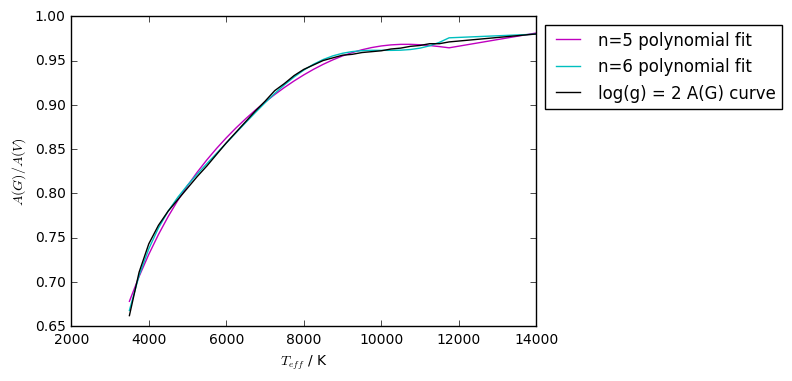

In [15]:
Teff_2 = (A_X_zs_gfix['2.0'])[:,0]
A_G_2 = (A_X_zs_gfix['2.0'])[:,2]


#fit2_p3 = np.polyfit(Teff_2,A_G_2,3)
#print fit0_p3

fit2_p3 = np.polyfit(Teff_2,A_G_2,3)
#print fit_G5zs_p3
fit2_p2,covout = np.polyfit(Teff_2,A_G_2,2,cov=True)
print fit_G5zs_p2
print covout
fit2_p4 = np.polyfit(Teff_2,A_G_2,4)
fit2_p5 = np.polyfit(Teff_2,A_G_2,5)
fit2_p6 = np.polyfit(Teff_2,A_G_2,6)
#print fit_G5zs_p4

predict2_2 = (fit2_p2[0])*Teff_2**2 + (fit2_p2[1])*Teff_2 +(fit2_p2[2])
predict2_3 = (fit2_p3[0])*Teff_2**3 + (fit2_p3[1])*Teff_2**2 + (fit2_p3[2])*Teff_2 +(fit2_p3[3])
predict2_4 = (fit2_p4[0])*Teff_2**4 + (fit2_p4[1])*Teff_2**3 + (fit2_p4[2])*Teff_2**2 + (fit2_p4[3])*Teff_2 + (fit2_p4[4])
predict2_5 = (fit2_p5[0])*Teff_2**5 + (fit2_p5[1])*Teff_2**4 + (fit2_p5[2])*Teff_2**3 + (fit2_p5[3])*Teff_2**2 + (fit2_p5[4])*Teff_2 +(fit2_p5[5])
predict2_6 = (fit2_p6[0])*Teff_2**6 + (fit2_p6[1])*Teff_2**5 + (fit2_p6[2])*Teff_2**4 + (fit2_p6[3])*Teff_2**3 + (fit2_p6[4])*Teff_2**2 + (fit2_p6[5])*Teff_2 +(fit2_p6[6])
print type(predict2_2), predict2_2.shape
print type(predict2_3), predict2_3.shape
print fit2_p5
print fit2_p6
fig,ax = plt.subplots()
#ax.set_title
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[2])

#ax.plot(Teff_5,predict_G5zs_2,'r', label = 'n=2 polynomial fit')
#ax.plot(Teff_5,predict_G5zs_3,'g', label = 'n=3 polynomial fit')
#ax.plot(Teff_5,predict_G5zs_4,'b', label = 'n=4 polynomial fit')
ax.plot(Teff_2,predict2_5,'m', label = 'n=5 polynomial fit')
ax.plot(Teff_2,predict2_6,'c', label = 'n=6 polynomial fit')
ax.plot(Teff_2,A_G_2,'k', label = 'log(g) = 2 A(G) curve')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

#scp.interpolate.griddata(,,,cubic)